In [ ]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 89.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 99.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 26.6 MB/s eta 0:00:00


In [1]:

import torch
import pandas as pd
from transformers import BertTokenizer, BertModel
import numpy as np



In [2]:

import matplotlib.pyplot as plt

%matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
%cd /content/drive/MyDrive/DOKTORA

/content/drive/MyDrive/DOKTORA


In [ ]:
df_layer_thickness = pd.read_csv("/content/drive/MyDrive/DOKTORA/df_layer_thickness.csv",index_col=0)

In [ ]:
df_material_names = pd.read_csv("/content/drive/MyDrive/DOKTORA/df_material_names.csv",index_col=0)

In [ ]:
df_material_names["sample"] = df_material_names["sample"].str.replace("nan","")
df_material_names["sample"] = df_material_names["sample"].str.strip()

In [ ]:
sentences = df_material_names["sample"].values.tolist()

In [3]:
text = "ZnAlOx Ag NiCr TiOx"#sentences[0]
marked_text = "[CLS] " + text  + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
segments_ids = [1] * len(tokenized_text)
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )
# Print out the tokens.
print (tokenized_text)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


['[CLS]', 'z', '##nal', '##ox', 'ag', 'nic', '##r', 'ti', '##ox', '[SEP]']


In [ ]:
material_dic = {i:tokenizer.tokenize(i) for i in ["ag","sin","nicr","znalox","tiox","sioxny","znsnox","nicrox"]}

In [ ]:
material_dic

{'ag': ['ag'],
 'sin': ['sin'],
 'nicr': ['nic', '##r'],
 'znalox': ['z', '##nal', '##ox'],
 'tiox': ['ti', '##ox'],
 'sioxny': ['si', '##ox', '##ny'],
 'znsnox': ['z', '##ns', '##no', '##x'],
 'nicrox': ['nic', '##ro', '##x']}

In [ ]:
def get_repet_thickness(sentence,thickness_array):
    material_len = [len(tokenizer.tokenize(i)) for i in sentence.split()]
    thickness_list = [[str(i)] for i in thickness_array.tolist()]

    thc_list_raw = []

    for inx,i in enumerate(material_len):
        thc_list_raw.append(i*thickness_list[inx])
    thc_list = sum(thc_list_raw, [])
    repet_thick_list = [float(i) for i in thc_list]
    repet_thick_array = np.array(repet_thick_list).reshape(-1,1)
    return repet_thick_array

In [ ]:
def preprocessing(sentence):
    marked_text = "[CLS] " + sentence  + " [SEP]"

    # Tokenize our sentence with the BERT tokenizer.
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    return tokens_tensor, segments_tensors

In [ ]:
thc = df_layer_thickness.iloc[0,:].values

In [ ]:
sample = 'SiN ZnAlOx Ag'
tokenizer.tokenize(sample)

['sin', 'z', '##nal', '##ox', 'ag']

In [ ]:
tokens_tensor, segments_tensors = preprocessing(sample)

In [ ]:
segments_tensors

tensor([[1, 1, 1, 1, 1, 1, 1]])

In [ ]:
tokens_tensor


tensor([[  101,  8254,  1062, 12032, 11636, 12943,   102]])

In [ ]:
embedding_list = []
for inx,sent in enumerate(sentences):
    thickness_array = df_layer_thickness.iloc[inx,:].values
    coating_sample = sent
    thickness_repet = get_repet_thickness(coating_sample,thickness_array)
    tokens_tensor, segments_tensors = preprocessing(coating_sample)
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]
    embed = hidden_states[12][0][1:-1]
    embed_array = np.array(embed)
    print(embed_array.shape)
    print(thickness_repet.shape)
    new_array = embed_array * thickness_repet ## burası önemli
    mean_embedding = new_array.mean(axis=0)
    print(mean_embedding.shape)
    embedding_list.append(mean_embedding)

In [ ]:
embedding_list_no_thickness = []
for inx,sent in enumerate(sentences):
    thickness_array = df_layer_thickness.iloc[inx,:].values
    coating_sample = sent
    thickness_repet = get_repet_thickness(coating_sample,thickness_array)
    tokens_tensor, segments_tensors = preprocessing(coating_sample)
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]
    embed = hidden_states[12][0][1:-1]
    embed_array = np.array(embed)
    print(embed_array.shape)
    print(thickness_repet.shape)
    new_array = embed_array# * thickness_repet ## burası önemli
    mean_embedding = new_array.mean(axis=0)
    print(mean_embedding.shape)
    embedding_list_no_thickness.append(mean_embedding)

In [ ]:
total_embedding = np.array(embedding_list)

In [ ]:
import joblib
joblib.dump(total_embedding,"total_embedding.h5")

['total_embedding.h5']

In [ ]:
import joblib
total_embedding = joblib.load("total_embedding.h5")

## Thickness array

In [ ]:
thickness = df_layer_thickness.iloc[0,:].values

## class transformers.BertTokenizer

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [4]:
sample = 'SiN ZnAlOx Ag'
# Print the original sentence.
print(' Original: ', sample)#sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sample))#sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sample)))#sentences[0])))

 Original:  SiN ZnAlOx Ag
Tokenized:  ['sin', 'z', '##nal', '##ox', 'ag']
Token IDs:  [8254, 1062, 12032, 11636, 12943]


In [ ]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  41


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)


# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

# UMAP

In [ ]:
import pandas as pd

In [ ]:
df_type = pd.read_csv("/content/drive/MyDrive/DOKTORA/bigdf_type.csv",index_col = 0)

In [ ]:
df_type

,type
id,
V2899,40/29
V3108,40/29
V3109,40/29
V3111,40/29
V3112,40/29
...,...
V2964,Low-E 1.0
V2970,Low-E 1.0
V2971,Low-E 1.0


In [ ]:
df_big = pd.read_pickle("/content/drive/MyDrive/DOKTORA/df_big_arranged.pkl")

In [ ]:
df_big["Ag"].value_counts()

1.0    165
2.0    100
3.0     53
Name: Ag, dtype: int64

In [ ]:
df_emb = pd.DataFrame(total_embedding,index =df_type.index )

In [ ]:
df_all = pd.concat([df_type,df_emb],axis = 1)

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [ ]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})


In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82827 sha256=d742d5665661f26f9548339bbcbca7b9221b0fb90c4f8512a95429191d6286bc
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55510 sha256=7cc81fc5fd11adf9f86ef69023c649880f2a52aa92b3a6ab57108d001a6681d4
  Stored in directory: /root/.cache/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
Successfully built umap-learn pynndescent


In [ ]:
import umap

In [ ]:
reducer = umap.UMAP()

In [ ]:
map_dic = {}
for inx,i in enumerate(df_all["type"].unique()):
    map_dic[i] = inx


In [ ]:
map_dic

{'40/29': 0,
 '41/27': 1,
 '50/27': 2,
 '50/33': 3,
 '51/29': 4,
 '60/28': 5,
 '62/44': 6,
 '70/37': 7,
 '71/53': 8,
 'YG Low-E': 9,
 'Low-E 1.0': 10}

In [ ]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [ ]:
coating_data = df_all.iloc[:,1:].values
scaled_coating_data = StandardScaler().fit_transform(coating_data)
embedding = reducer.fit_transform(scaled_coating_data)
df_umap = pd.DataFrame(embedding,columns=["dim1","dim2"],index = df_type.index)

In [ ]:
df_umap_new = pd.concat([df_umap,df_big],axis=1)

In [ ]:
pd.options.display.max_rows=2000
pd.options.display.max_columns=2000

[Text(0.5, 1.0, 'The umap projection BERT embeddings in terms of product type')]

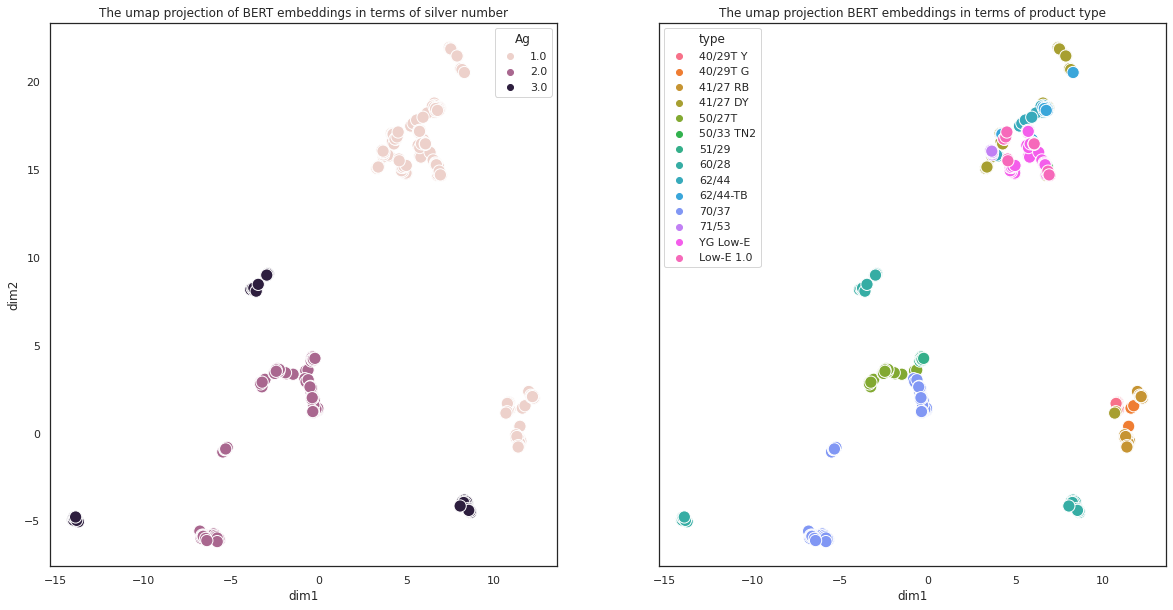

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
sns.scatterplot(ax=axes[0],data=df_umap_new, x="dim1", y="dim2", hue="Ag",s=150).set(title='The umap projection of BERT embeddings in terms of silver number')
sns.scatterplot(ax=axes[1],data=df_umap_new, x="dim1", y="dim2", hue="type",s=150).set(title='The umap projection BERT embeddings in terms of product type')

In [ ]:
joblib.dump(embedding,"umap_embedding.h5")

## Tsne experiments


In [ ]:
from sklearn import manifold

In [ ]:
X_embedded_1dim = manifold.TSNE(n_components=1, learning_rate='auto',init='random').fit_transform(coating_data)

In [ ]:
X_embedded_2dim = manifold.TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(coating_data)

In [ ]:
X_embedded_4dim = manifold.TSNE(n_components=4,method="exact", learning_rate='auto',init='random').fit_transform(coating_data)

In [ ]:
X_embedded_8dim = manifold.TSNE(n_components=8,method="exact", learning_rate='auto',init='random').fit_transform(coating_data)

In [ ]:
X_embedded_16dim = manifold.TSNE(n_components=16,method="exact", learning_rate='auto',init='random').fit_transform(coating_data)

In [ ]:
X_embedded_32dim = manifold.TSNE(n_components=32,method="exact", learning_rate='auto',init='random').fit_transform(coating_data)

In [ ]:
X_embedded_64dim = manifold.TSNE(n_components=64,method="exact", learning_rate='auto',init='random').fit_transform(coating_data)

In [ ]:
X_embedded_128dim = manifold.TSNE(n_components=128,method="exact", learning_rate='auto',init='random').fit_transform(coating_data)

In [ ]:
X_embedded_4dim = manifold.TSNE(n_components=4,method="exact", learning_rate='auto',init='random').fit_transform(coating_data)

In [ ]:
%cd "/content/drive/MyDrive/DOKTORA"

In [ ]:
joblib.dump(X_embedded_1dim,"X_embedded_1dim.h5")

In [ ]:
joblib.dump(X_embedded_2dim,"X_embedded_2dim.h5")

In [ ]:
joblib.dump(X_embedded_4dim,"X_embedded_4dim.h5")

In [ ]:
joblib.dump(X_embedded_8dim,"X_embedded_8dim.h5")
joblib.dump(X_embedded_16dim,"X_embedded_16dim.h5")
joblib.dump(X_embedded_32dim,"X_embedded_32dim.h5")

In [ ]:
joblib.dump(X_embedded_64dim,"X_embedded_64dim.h5")
joblib.dump(X_embedded_128dim,"X_embedded_128dim.h5")

In [ ]:
plt.scatter(
    X_embedded_1dim[:, 0],
    X_embedded_1dim[:, 0],
    c=[sns.color_palette("Paired")[x] for x in df_all["type"].map(map_dic)])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Penguin dataset', fontsize=24)

# PCA

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

In [ ]:
coating_data.shape

In [ ]:
pca = PCA()
pca.fit(coating_data)


print(pca.explained_variance_ratio_)
print(pca.singular_values_)
